# Modeling

## Import Libraries and the final salary data set

In [18]:
import time
import nltk
from nltk.corpus import stopwords

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
import string, re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [19]:
salary_df = pd.read_csv("salary_final.csv")

In [20]:
salary_df.head()

,Unnamed: 0,Unnamed: 0.1,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,...,adjusted_yearly_salary,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text
0,0,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re..."
1,1,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,"2021048 Data Scientist $215,000.00 Position Re..."
2,2,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...
3,3,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,Data Science/Data Analyst Cost Readiness Analy...
4,4,8,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,...,46800.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1267b3588>]],
      dtype=object)

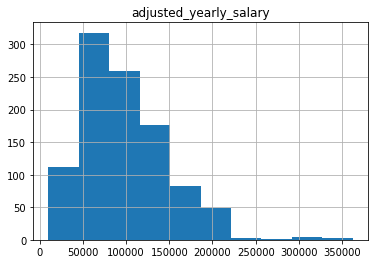

In [21]:
salary_df.hist('adjusted_yearly_salary')

In [22]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

Salary bins: [< 50,000, 50,000-75,000, 75,000-100,000, 100,000-125,000, 125,000-150,000, 150,000-175,000, 175,000-200,000, 200,000-225,000, 225,000-250,000, >250,000]

In [23]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,11)))

0.0     10000.00
0.1     44916.00
0.2     57796.00
0.3     67500.00
0.4     77500.00
0.5     91434.00
0.6    105000.00
0.7    119421.00
0.8    140000.00
0.9    168143.44
1.0    362500.00
Name: adjusted_yearly_salary, dtype: float64

In [24]:
#Create Bins
BINS = [0,50000,75000,100000,125000,150000,175000,200000,400000]

In [25]:
salary_df['Salary_Bins'] = pd.cut(x=salary_df['adjusted_yearly_salary'], bins=BINS, labels=False)

In [26]:
salary_df['Salary_Bins']

0       7
1       7
2       1
3       1
4       0
       ..
1003    3
1004    2
1005    2
1006    2
1007    2
Name: Salary_Bins, Length: 1008, dtype: int64

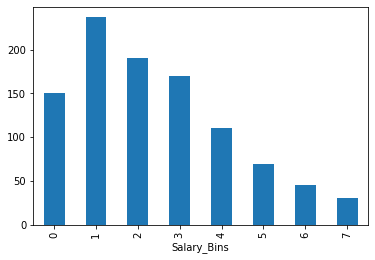

In [27]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()

In [28]:
#Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [29]:
data = clean_word(salary_df['combined_text'])
target = salary_df['adjusted_yearly_salary'] #continuous target
target_class = salary_df['Salary_Bins'].astype('category') #categorical target

## Model 1:  Use Word2Vec Model 

We are going to use Word2Vec model in this section. Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

We need to specify following parameter to the model:
* the `size` of the word vectors we want to learn 
* the `window` size to use when training the model
* `min_count`, which corresponds to the minimum number of times a word must be used in the corpus in order to be included in the training (for instance, `min_count=5` would only learn word embeddings for words that appear 5 or more times throughout the entire training set)
* `workers`, the number of threads to use for training, which can speed up processing (`4` is typically used, since most processors nowadays have at least 4 cores)

In [30]:
data[0]

['data',
 'scientist',
 'position',
 'requires',
 'top',
 'secret',
 'ts',
 'sci',
 'clearance',
 'polygraph',
 'estimated',
 'salary',
 'position',
 'level',
 'level',
 'subject',
 'matter',
 'expert',
 'salary',
 'range',
 'per',
 'year',
 'b',
 'corp',
 'estimated',
 'salary',
 'ranges',
 'position',
 'level',
 'min',
 'salary',
 'max',
 'salary',
 'level',
 'subject',
 'matter',
 'expert',
 'level',
 'expert',
 'level',
 'senior',
 'level',
 'full',
 'performance',
 'mandatory',
 'requirements',
 'java',
 'development',
 'experience',
 'production',
 'environment',
 'required',
 'software',
 'developer',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'troubleshooting',
 'user',
 'issues',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'writing',
 'system',
 'automation',
 'scripts',
 'linux',
 'environment',
 'using',
 'tools',
 'bash',
 'sh',
 'python',
 'ruby',
 'perl',
 'list',
 'years',
 'experience',
 'demonstrated',
 'jo

### Random Forest Regressor,  Linear SVC and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.


https://scikit-learn.org/stable/modules/classes.html
#module-sklearn.feature_extraction.text
https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

#### Word2Vec Model from scratch

In [40]:
model = Word2Vec(data,
                size=500,
                window=5,
                min_count=2,
                workers=4)

In [41]:
model.train(data,total_examples=model.corpus_count, epochs=10)

(3431362, 3673340)

In [42]:
wv = model.wv

In [43]:
wv.vector_size

500

In [44]:
wv.most_similar('data')

[('extraction', 0.5246098637580872),
 ('cleaning', 0.5221850872039795),
 ('unstructured', 0.517565906047821),
 ('etl', 0.5145159363746643),
 ('sets', 0.5127720236778259),
 ('large', 0.5070561170578003),
 ('manipulate', 0.49055036902427673),
 ('dashboards', 0.49043816328048706),
 ('raw', 0.4901886582374573),
 ('manipulating', 0.48749840259552)]

To be able to use in a pipeline, need fit and transform

In [45]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [46]:
len(w2v.values())

9364

Averaging word vectors for all words in a text.

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [47]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=3, verbose=True, n_jobs=3))])

svc = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Support Vector Machine', SVC(kernel='rbf', C=0.5))])

sgd = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
               ('Stochastic Gradient Descent', SGDClassifier(alpha=0.001, n_jobs=3))])

#svr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('SVR-lin', SVR(kernel='rbf', C=0.5))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [51]:
rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=3, verbose=True, n_jobs=3))])


In [ ]:
cross_val_score(rf, data, target_class, cv=2).mean()

In [48]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Stochastic Gradient Descent', sgd)]
          #('Linear Regression', lr)]

In [49]:
scores = [(name, cross_val_score(model, data, target_class, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished


In [50]:
scores

[('Random Forest', 0.3680555555555556),
 ('Support Vector Machine', 0.33134920634920634),
 ('Stochastic Gradient Descent', 0.33333333333333337)]

TD-IDF Embedding

In [42]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [43]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svc = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Support Vector Machine', SVC(kernel='rbf', C=0.5))])

#svr = Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
             # ('SVR-lin', SVR(kernel='rbf'))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [44]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc)]
          #('Linear Regression', lr)]

In [45]:
scores = [(name, cross_val_score(model, data, target_class, cv=2).mean()) for name, model, in models]

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NameError: name 'defaultdict' is not defined

  FitFailedWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NameError: name 'defaultdict' is not defined

  FitFailedWarning)


In [46]:
scores

[('Random Forest', nan), ('Support Vector Machine', 0.3208715418258987)]

#### Try other vectorizers with GridSearch


In [49]:
!pip install pprint

  Using cached https://files.pythonhosted.org/packages/99/12/b6383259ef85c2b942ab9135f322c0dce83fdca8600d87122d2b0181451f/pprint-0.1.tar.gz
  Created wheel for pprint: filename=pprint-0.1-cp37-none-any.whl size=1250 sha256=cacd71b09028f9b2b9349d4e7c4a38ccd3cd6fe3d0565d644a9463403cf1d03d
  Stored in directory: /Users/bonniema/Library/Caches/pip/wheels/42/d4/c6/16a6495aecc1bda5d5857bd036efd50617789ba9bea4a05124
Successfully built pprint


In [50]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [52]:
text = salary_df['combined_text']

In [53]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(text, target_class)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


done in 67.460s

Best score: 0.453
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


Confusion matrix to interpret the score better. If predicting lower bins better, can combine some of them.  

### Use Pretrained GloVe Model

#### Getting the Total Vocabulary

In [24]:
total_vocabulary = set(word for jd in data for word in jd)

In [25]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13283 unique tokens in the dataset.


In [26]:
#Get the appropriate vectors out of the GloVe file
glove = {}
with open('glove_6B_50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [18]:
glove['data']

array([ 5.3101e-01, -5.5869e-01,  1.7674e+00,  4.4824e-01,  2.2341e-01,
       -3.4559e-01, -7.7679e-01, -9.6117e-01,  1.1669e+00,  7.4279e-02,
        8.1470e-01, -5.9428e-02,  6.4599e-02,  1.5176e-03,  9.9179e-02,
        3.6602e-01, -9.8724e-01, -8.3913e-01,  1.5917e-01, -7.7603e-01,
        7.3474e-01, -6.4861e-01,  4.6174e-01,  8.8162e-03,  5.1738e-01,
       -6.5976e-01, -7.4010e-01, -1.3928e-01,  8.1094e-02,  2.0657e-01,
        3.5652e+00, -8.2264e-01,  5.7360e-01, -1.7268e+00,  6.2356e-03,
        6.7672e-02, -2.3411e-01,  3.5163e-02,  2.6507e-01, -2.9966e-01,
        7.4323e-01, -4.5027e-01,  1.9406e-01,  4.8611e-01, -4.3075e-01,
       -2.5210e-01,  1.2774e+00,  1.5815e+00,  6.5838e-01, -2.0978e-01],
      dtype=float32)

In [ ]:
len(next(iter(glove)))

In [27]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

To be able to use in a pipeline, need fit and transform

### Use Random Forest Regressor and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.

In [28]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVR(kernel='linear'))])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Linear Regression', LinearRegression())])

In [30]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svr),
          ('Linear Regression', lr)]

In [31]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  89 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
scores

[('Random Forest', 0.23296344891439746),
 ('Support Vector Machine', -0.12380575212964273),
 ('Linear Regression', 0.21515161505580238)]

The score is pretty low. There is plenty of room to improve the model performance: standardize the scale of salary, add more parameters to the regression model.

## Model 2: Deep Learning Models with Word Embeddings

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten

from keras.utils import to_categorical

Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/t

In [14]:
print(target_class)

0      7
1      1
2      0
3      2
4      3
      ..
958    3
959    2
960    2
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]


In [15]:
#Encoding to categorical classes
y = to_categorical(target_class.values, num_classes=8, dtype="float32")


In [16]:
y.shape

(963, 8)

In [17]:
tokenizer = text.Tokenizer() #limit the number of words
tokenizer.num_words = 500
tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = tokenizer.texts_to_sequences(salary_df['combined_text'])
X_t = sequence.pad_sequences(list_tokenized_jd, maxlen=100)

In [18]:
len(list_tokenized_jd)

963

In [19]:
X_t.shape

(963, 100)

In [28]:
y.shape

(963, 8)

#### Train-Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=4)

In [30]:
X_test.shape

(97, 100)

In [32]:
y_test.shape

(97, 8)

In [41]:
X_train[0]

array([ 75,   1,  27, 265,   8,  53, 217, 109,   1,  55,  21,  19,   3,
        27, 107, 436, 323, 113,   3,  75, 393,   4,  21,   7,  44, 277,
        35, 139,   1,  16, 139,   7,   8,   3, 114, 186, 211,  97, 146,
        23, 448,  12,   7,  71,  13,  12,   7,   1, 284,   7,   7, 211,
        73,  89,  14, 341,   1, 448,  65,   5, 133,  69,  10, 272,   8,
         3, 114, 186, 211,  97, 146, 469,  52,  52, 102,  13, 144, 142,
       455, 186, 211,  97, 211,  97, 114,  97, 211, 181,  48, 277, 439,
       293, 211, 364,  35,  71,  35,  75,  35, 105], dtype=int32)

In [42]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [61]:
#Transform features by scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler

scalarX_train, scalarX_test, scalarY_train, scalarY_test = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
scalarX_train.fit(X_train)
scalarY_train.fit(y_train.reshape(866,1))
scalarX_test.fit(X_test)
scalarY_test.fit(y_test.reshape(97,1))
X_train_new = scalarX_train.transform(X_train)
y_train_new = scalarY_train.transform(y_train.reshape(866,1))
X_test_new = scalarX_test.transform(X_test)
y_test_new = scalarY_test.transform(y_test.reshape(97,1))

In [62]:
X_train_new.shape

(866, 100)

In [63]:
y_train_new.shape

(866, 1)

In [43]:
model = Sequential()

embedding_size = 64
model.add(Embedding(output_dim = 64, input_dim = 500, input_length = 100)) #try 100, 200, single LSTM and single dense 100
model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(64))
#model.add(GlobalMaxPool1D())
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(8, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 64)           32000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          98816     
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100)          12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 80008     
Total params: 223,724
Trainable params: 223,724
Non-trainable params: 0
________________________________________________

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [48]:
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=[X_test, y_test])

Train on 866 samples, validate on 97 samples
Epoch 1/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0540 - accuracy: 0.9815 - val_loss: 4.0606 - val_accuracy: 0.4536
Epoch 2/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0546 - accuracy: 0.9861 - val_loss: 4.3161 - val_accuracy: 0.4639
Epoch 3/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0834 - accuracy: 0.9827 - val_loss: 4.1485 - val_accuracy: 0.4536
Epoch 4/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0613 - accuracy: 0.9827 - val_loss: 3.9984 - val_accuracy: 0.4433
Epoch 5/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0451 - accuracy: 0.9885 - val_loss: 4.2243 - val_accuracy: 0.4639
Epoch 6/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0303 - accuracy: 0.9931 - val_loss: 4.3117 - val_accuracy: 0.4845
Epoch 7/80
866/866 [==============================] - 2s 3ms/step - loss: 0.1588 - accuracy: 0.9515 - v

866/866 [==============================] - 2s 3ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 4.9054 - val_accuracy: 0.4021
Epoch 59/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0178 - accuracy: 0.9931 - val_loss: 4.7997 - val_accuracy: 0.4433
Epoch 60/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0155 - accuracy: 0.9965 - val_loss: 4.9629 - val_accuracy: 0.4021
Epoch 61/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0121 - accuracy: 0.9942 - val_loss: 4.9184 - val_accuracy: 0.4124
Epoch 62/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 4.9307 - val_accuracy: 0.4227
Epoch 63/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0143 - accuracy: 0.9931 - val_loss: 4.9947 - val_accuracy: 0.4227
Epoch 64/80
866/866 [==============================] - 2s 3ms/step - loss: 0.0113 - accuracy: 0.9931 - val_loss: 4.8927 - val_accuracy: 0.4227
Epoch 65/80

Hyperparameter testing (layer size, learning rate) 
Grid Search: https://github.com/autonomio/talos
Google Collab

In [49]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [50]:
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0006
Validation MSE: 0.1275

Training r2: 0.9935
Validation r2: -0.1496


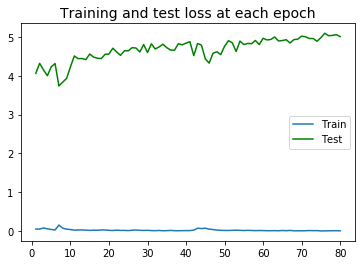

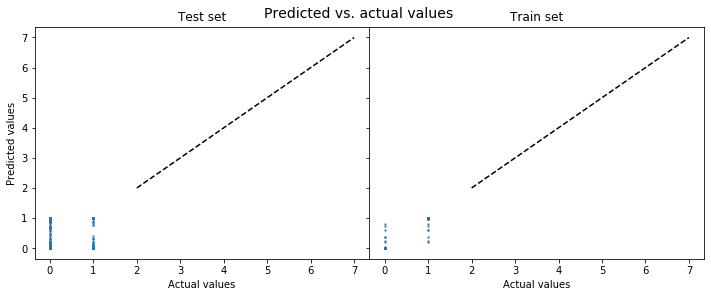

In [53]:
nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)